<a href="https://colab.research.google.com/github/niveditanayak2003/CRM-Data-Cleaning-and-Analysis/blob/main/DataAccuracyInCRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score, confusion_matrix

# Mount Google Drive
drive.mount('/content/drive',force_remount=True)

# Load the dataset
file_path = '/content/drive/My Drive/Dataset/uncleaned_crm_data.xlsx'
data = pd.read_excel(file_path)

# Ensure dataset is not empty
if data.empty:
    raise ValueError("Error: Dataset is empty or not loaded properly!")

# Ensure required columns exist
required_columns = {'email', 'name', 'age', 'valid'}
missing_cols = required_columns - set(data.columns)
if missing_cols:
    print(f"Warning: The following columns are missing in the dataset: {missing_cols}")

# Correct misspelled 'gmail' in email addresses
def correct_gmail(email):
    if isinstance(email, str):
        return re.sub(r'\b(gmial|gmaill|gmai|gmal|gmaul|gmeil)\.com\b', 'gmail.com', email, flags=re.IGNORECASE)
    return email

if 'email' in data.columns:
    data['email'] = data['email'].str.lower().apply(correct_gmail)

# Fill missing names using email prefix
def extract_name_from_email(email):
    if isinstance(email, str) and '@' in email:
        return email.split('@')[0]
    return 'Unknown'

if 'name' in data.columns and 'email' in data.columns:
    data['name'].fillna(data['email'].apply(lambda x: extract_name_from_email(x)), inplace=True)

# Remove duplicates using TF-IDF & DBSCAN
if 'name' in data.columns and 'email' in data.columns:
    data['combined'] = data['name'].fillna('') + ' ' + data['email'].fillna('')

    # Apply TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(data['combined'])

    # DBSCAN Clustering with dynamic epsilon selection
    eps_values = np.linspace(0.3, 1.0, 5)
    best_eps, best_score = None, -1

    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=2, metric='cosine')
        clusters = dbscan.fit_predict(X)

        # Only compute silhouette score if more than one cluster
        if len(set(clusters)) > 1:
            score = silhouette_score(X, clusters)
            if score > best_score:
                best_score, best_eps = score, eps

    if best_eps:
        data['cluster'] = DBSCAN(eps=best_eps, min_samples=2, metric='cosine').fit_predict(X)
    else:
        print("Warning: DBSCAN did not find multiple clusters.")

# Missing Value Imputation with Linear Regression & KNN
if 'age' in data.columns:
    train_data = data[data['age'].notnull()]
    predict_data = data[data['age'].isnull()]

    if not train_data.empty and not predict_data.empty:
        X_train = pd.get_dummies(train_data.drop(columns=['age', 'combined', 'cluster'], errors='ignore'), drop_first=True)
        y_train = train_data['age']

        # Ensure no missing values in training features
        imputer = SimpleImputer(strategy='mean')
        X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

        model = LinearRegression()
        model.fit(X_train, y_train)

        # Prepare data for prediction
        X_predict = pd.get_dummies(predict_data.drop(columns=['age', 'combined', 'cluster'], errors='ignore'), drop_first=True)
        X_predict = X_predict.reindex(columns=X_train.columns, fill_value=0)
        X_predict = pd.DataFrame(imputer.transform(X_predict), columns=X_predict.columns)

        # Predict missing ages
        data.loc[data['age'].isnull(), 'age'] = model.predict(X_predict)

# Apply KNN Imputation for remaining missing values
knn_imputer = KNNImputer(n_neighbors=5)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = knn_imputer.fit_transform(data[numeric_columns])

# Anomaly Detection using Decision Tree & Logistic Regression
if 'valid' in data.columns:
    X = pd.get_dummies(data.drop(columns=['valid', 'combined', 'cluster'], errors='ignore'), drop_first=True)
    y = data['valid']

    # Handle missing values before training
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt_clf.fit(X_train, y_train)
    dt_predictions = dt_clf.predict(X_test)

    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    log_predictions = log_reg.predict(X_test)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, dt_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Save the cleaned dataset
cleaned_file_path = '/content/drive/My Drive/Dataset/cleaned_data.xlsx'
data.to_excel(cleaned_file_path, index=False)
print(f"Cleaned data saved to: {cleaned_file_path}")


Mounted at /content/drive
Cleaned data saved to: /content/drive/My Drive/Dataset/cleaned_data.xlsx


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Dataset Loaded:
    Customer_ID Customer_Name           Email            Phone   Revenue  \
0         2824       Charlie    EVE@MAIL.COM  +1-202-555-0193  11646.21   
1         1409         Alice    EVE@MAIL.COM     123.456.7890  12569.52   
2         5506         Alice    BOB@MAIL.COM   (555) 234-5678  49065.46   
3         5012         David  DAVID@MAIL.COM   (555) 234-5678  45183.11   
4         4657           Eve    BOB@MAIL.COM       5552345678   3966.95   

   Customer_Age Customer_Type Region  
0          57.0           New   East  
1          49.0     Returning   East  
2          26.0     Returning  South  
3          46.0           New   West  
4          63.0           New    NaN  

Cleaned Dataset Loaded:
    Customer_ID Customer_Name           Email            Phone   Revenue  \
0         2824       Charlie    EVE@MAIL.COM  +1-202-555-01

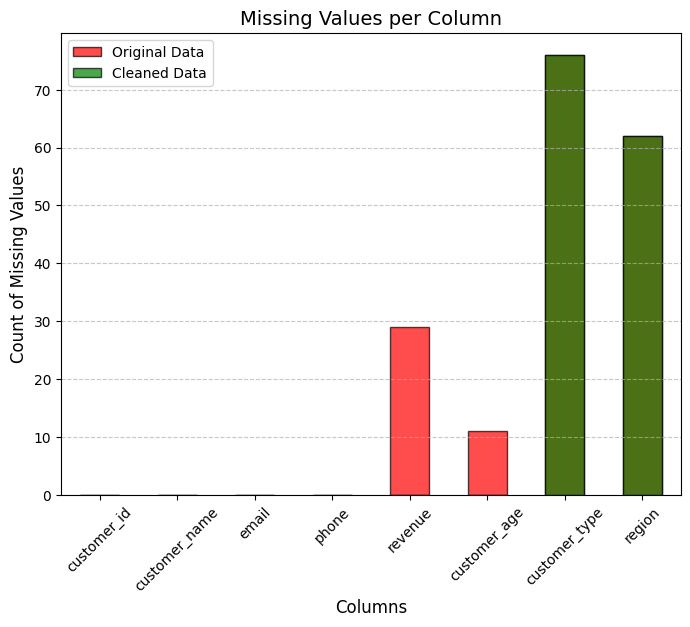

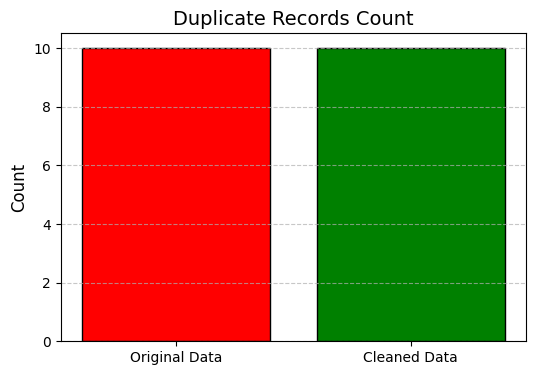

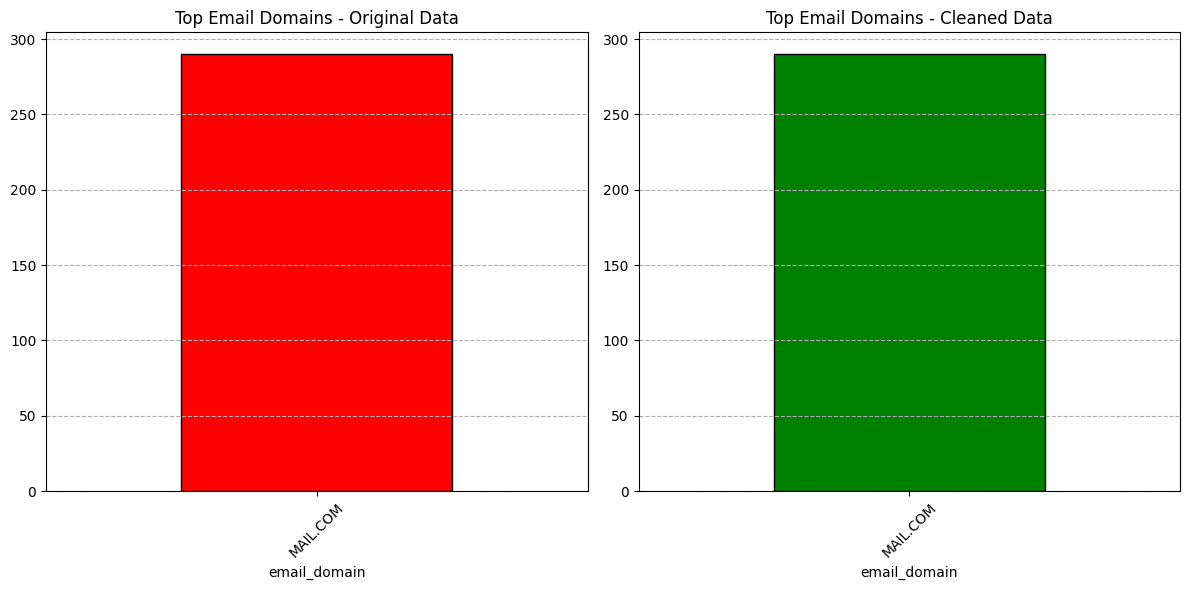


Summary report saved to: /content/drive/My Drive/Dataset/summary_report.xlsx

✅ CRM Data Visualization Completed Successfully!


In [2]:
# Import necessary libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# 🔹 Mount Google Drive
drive.mount('/content/drive')

# 🔹 Define file paths
file_path_old = '/content/drive/My Drive/Dataset/uncleaned_crm_data.xlsx'  # Original dataset
file_path_cleaned = '/content/drive/My Drive/Dataset/cleaned_data.xlsx'  # Cleaned dataset

# 🔹 Check if cleaned data exists before loading
if os.path.exists(file_path_old):
    data_old = pd.read_excel(file_path_old)
else:
    raise FileNotFoundError(f"Error: The original dataset file was not found at {file_path_old}")

if os.path.exists(file_path_cleaned):
    data_cleaned = pd.read_excel(file_path_cleaned)
else:
    print(f"Warning: Cleaned dataset file not found at {file_path_cleaned}. Proceeding with original data only.")
    data_cleaned = None  # Handle gracefully

# 🔹 Display first few rows
print("Original Dataset Loaded:\n", data_old.head())

if data_cleaned is not None:
    print("\nCleaned Dataset Loaded:\n", data_cleaned.head())

# 🔹 Ensure column names are lowercase for consistency
data_old.columns = data_old.columns.str.lower()
if data_cleaned is not None:
    data_cleaned.columns = data_cleaned.columns.str.lower()

# ✅ Visualization 1: Missing Values Count
plt.figure(figsize=(8, 6))
data_old.isnull().sum().plot(kind='bar', color='red', edgecolor='black', alpha=0.7, label='Original Data')

if data_cleaned is not None:
    data_cleaned.isnull().sum().plot(kind='bar', color='green', edgecolor='black', alpha=0.7, label='Cleaned Data')

plt.title("Missing Values per Column", fontsize=14)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Count of Missing Values", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ✅ Visualization 2: Duplicate Records Count
duplicates_old = data_old.duplicated().sum()
duplicates_cleaned = data_cleaned.duplicated().sum() if data_cleaned is not None else 0

plt.figure(figsize=(6, 4))
plt.bar(["Original Data", "Cleaned Data"], [duplicates_old, duplicates_cleaned], color=["red", "green"], edgecolor="black")
plt.title("Duplicate Records Count", fontsize=14)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ✅ Visualization 3: Age Distribution Before & After Cleaning
if 'age' in data_old.columns and (data_cleaned is None or 'age' in data_cleaned.columns):
    plt.figure(figsize=(10, 5))
    sns.histplot(data_old['age'].dropna(), kde=True, color='red', bins=20, label='Original Data')

    if data_cleaned is not None:
        sns.histplot(data_cleaned['age'].dropna(), kde=True, color='green', bins=20, label='Cleaned Data')

    plt.title("Age Distribution Before & After Cleaning")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

# ✅ Visualization 4: Email Domain Distribution Before & After Cleaning
if 'email' in data_old.columns and (data_cleaned is None or 'email' in data_cleaned.columns):
    data_old['email_domain'] = data_old['email'].str.split('@').str[-1]
    if data_cleaned is not None:
        data_cleaned['email_domain'] = data_cleaned['email'].str.split('@').str[-1]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    data_old['email_domain'].value_counts().nlargest(10).plot(kind='bar', color='red', edgecolor='black')
    plt.title("Top Email Domains - Original Data")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')

    if data_cleaned is not None:
        plt.subplot(1, 2, 2)
        data_cleaned['email_domain'].value_counts().nlargest(10).plot(kind='bar', color='green', edgecolor='black')
        plt.title("Top Email Domains - Cleaned Data")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

# ✅ Visualization 5: City Distribution Comparison
if 'city' in data_old.columns and (data_cleaned is None or 'city' in data_cleaned.columns):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    data_old['city'].value_counts().nlargest(10).plot(kind='bar', color='red', edgecolor='black')
    plt.title("Top 10 Cities - Original Data")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--')

    if data_cleaned is not None:
        plt.subplot(1, 2, 2)
        data_cleaned['city'].value_counts().nlargest(10).plot(kind='bar', color='green', edgecolor='black')
        plt.title("Top 10 Cities - Cleaned Data")
        plt.xticks(rotation=45)
        plt.ylabel("Count")
        plt.grid(axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

# ✅ Save a summary of missing and duplicate records (if cleaned dataset exists)
if data_cleaned is not None:
    summary = {
        "Total Records": [len(data_cleaned)],
        "Duplicate Records": [duplicates_cleaned],
        "Missing Values (Total)": [data_cleaned.isnull().sum().sum()]
    }
    summary_df = pd.DataFrame(summary)
    summary_file_path = '/content/drive/My Drive/Dataset/summary_report.xlsx'
    summary_df.to_excel(summary_file_path, index=False)
    print(f"\nSummary report saved to: {summary_file_path}")

print("\n✅ CRM Data Visualization Completed Successfully!")
